<a href="https://colab.research.google.com/github/SergeiVKalinin/MSE_Spring2025/blob/main/Module_4/23_PI_DeepONet_parameter.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Physics Informed Deep Neural Operators
- Based on: https://towardsdatascience.com/operator-learning-via-physics-informed-deeponet-lets-implement-it-from-scratch-6659f3179887/
- Code at: https://github.com/ShuaiGuo16/PI-DeepONet/tree/main

### Objective

In this notebook, we develop a PI-DeepONet model that can tackle inverse problems. Specifically, we investigate the following example equation:

\begin{equation}
\frac{ds(t)}{dt} = a \cdot u(t)+b, \; t \in [0, 1]
\end{equation}

with an initial condition $s(0)=0$, and our goal is to estimate unknown parameters a and b given the observed input and output functions.

### 0. Import libraries

In [16]:
!pip install keras==2.14.0 tensorflow==2.14.0

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 21.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 489.9/489.9 MB 3.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 37.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 51.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 440.7/440.7 kB 18.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.4/78.4 kB 6.1 MB/s eta 0:00:00
  Attempting uninstall: wrapt
    Found existing installation: wrapt 1.17.2
    Uninstalling wrapt-1.17.2:
      Successfully uninstalled wrapt-1.17.2
  Attempting uninstall: ml-dtypes
    Found existing installation: ml-dtypes 0.4.1
    Uninstalling ml-dtypes-0.4.1:
      Successfully uninstalled ml-dtypes-0.4.1
  Attempting uninstall: keras
    Found existing installation: keras 3.8.0
    Uninstalling keras-3.8.0:
      Successfully uninstalled keras-3.8.0
  Attempting uninstall: google-auth-oauthlib
    Found existing ins

In [1]:
# Common packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from sklearn.model_selection import train_test_split
from collections import defaultdict
from tqdm import tqdm
import time

import tensorflow as tf
from tensorflow import keras
tf.random.set_seed(42)

from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF
from scipy.integrate import solve_ivp

from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error

### 1. Data generation

We use a zero-mean Gaussian Process to generate the dataset for both training and testing.

In [2]:
def create_samples(length_scale, sample_num):
    """Create synthetic data for u(·)

    Args:
    ----
    length_scale: float, length scale for RNF kernel
    sample_num: number of u(·) profiles to generate

    Outputs:
    --------
    u_sample: generated u(·) profiles
    """

    # Define kernel with given length scale
    kernel = RBF(length_scale)

    # Create Gaussian process regressor
    gp = GaussianProcessRegressor(kernel=kernel)

    # collocation point locations
    X_sample = np.linspace(0, 1, 100).reshape(-1, 1)

    # create samples
    u_sample = np.zeros((sample_num, 100))
    for i in range(sample_num):
        n = np.random.randint(0, 10000)
        u_sample[i, :] = gp.sample_y(X_sample, random_state=n).flatten()  # sampling from the prior

    return u_sample

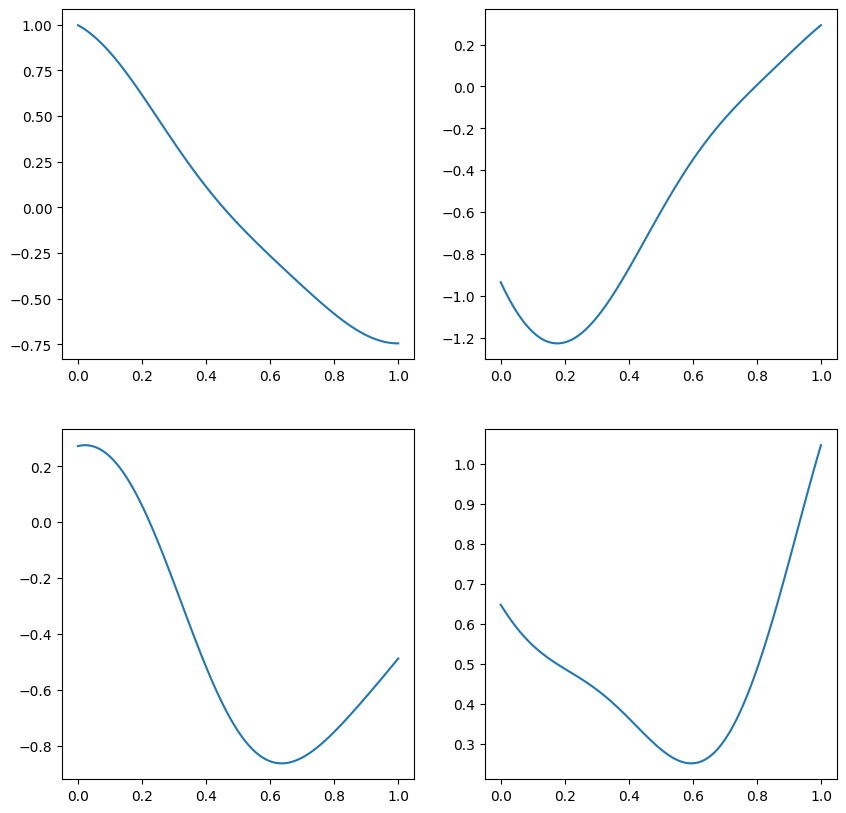

In [3]:
# Inspect generated data
length_scale = 0.4
N = 20
X_sample = np.linspace(0, 1, 100).reshape(-1, 1)
y_sample = create_samples(length_scale, N)

fig, axs = plt.subplots(2, 2, figsize=(10, 10))
index = np.random.choice(np.arange(0, N), size=4, replace=False)
for i in range(4):
    ax = axs[i // 2, i % 2]
    ax.plot(X_sample, y_sample[index[i]])

### 2. Organize dataset for PI-DeepONet

In [4]:
def generate_dataset(N, length_scale, a, b, ODE_solve=False):
    """Generate dataset for Physics-informed DeepONet training.

    Args:
    ----
    N: int, number of u(·) profiles
    length_scale: float, length scale for RNF kernel
    ODE_solve: boolean, indicate whether to compute the corresponding s(·)

    Outputs:
    --------
    X: the dataset for t, u(·) profiles, and u(t)
    y: the dataset for the corresponding ODE solution s(·)
    """

    # Create random fields
    random_field = create_samples(length_scale, N)

    # Compile dataset
    X = np.zeros((N*100, 100+2))
    y = np.zeros((N*100, 1))

    for i in tqdm(range(N)):
        u = np.tile(random_field[i, :], (100, 1))
        t = np.linspace(0, 1, 100).reshape(-1, 1)

        # u(·) evaluated at t
        u_t = np.diag(u).reshape(-1, 1)

        # Update overall matrix
        X[i*100:(i+1)*100, :] = np.concatenate((t, u, u_t), axis=1)

        # Solve ODE
        if ODE_solve:
            sol = solve_ivp(lambda var_t, var_s: a*np.interp(var_t, t.flatten(), random_field[i, :])+b,
                            t_span=[0, 1], y0=[0], t_eval=t.flatten(), method='RK45')
            y[i*100:(i+1)*100, :] = sol.y[0].reshape(-1, 1)

    return X, y

In [5]:
# Define true parameter values
a, b = 0.5, 0.5

# Create training dataset
N_train = 2000
length_scale_train = 0.4
X_train, y_train = generate_dataset(N_train, length_scale_train, a, b, ODE_solve=True)

# Create validation dataset
N_val = 100
length_scale_test = 0.4
X_val, y_val = generate_dataset(N_val, length_scale_test, a, b, ODE_solve=True)

# Create testing dataset
N_test = 100
length_scale_test = 0.4
X_test, y_test = generate_dataset(N_test, length_scale_test, a, b, ODE_solve=True)

100%|██████████| 100/100 [00:00<00:00, 537.97it/s]


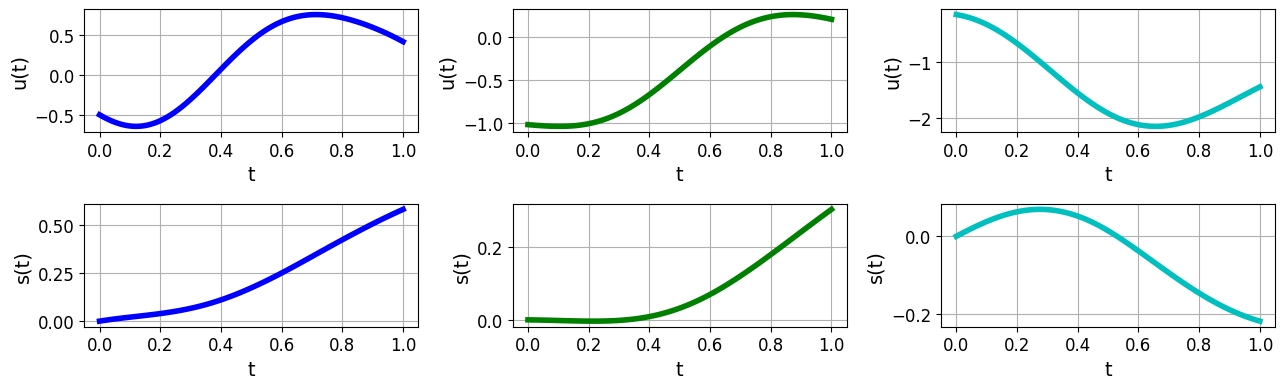

In [6]:
%matplotlib inline
color = ['b', 'g', 'c']
fig, axs = plt.subplots(2, 3, figsize=(13, 4))
sample_id = np.random.choice(np.arange(0, 100), size=3, replace=False)
for i in range(3):
    ax = axs[0, i]
    ax.plot(np.linspace(0, 1, 100), X_test[sample_id[i]*100, 1:-1], lw=4, c=color[i])
    ax.set_xlabel('t', fontsize=14)
    ax.set_ylabel('u(t)', fontsize=14)
    ax.tick_params(axis='both', which='major', labelsize=12)
    ax.grid(True)


    ax = axs[1, i]
    ax.plot(np.linspace(0, 1, 100), y_test[sample_id[i]*100:(sample_id[i]+1)*100, :], lw=4, c=color[i])
    ax.set_xlabel('t', fontsize=14)
    ax.set_ylabel('s(t)', fontsize=14)
    ax.tick_params(axis='both', which='major', labelsize=12)
    ax.grid(True)

plt.tight_layout()
plt.savefig('inverse_param_sample.png', bbox_inches='tight', transparent=True)

#### Separate initial condition and collocation points

In [7]:
# Determine batch size
ini_batch_size = int(2000/100)
col_batch_size = 2000

# Create dataset object (initial conditions)
X_train_ini = tf.convert_to_tensor(X_train[X_train[:, 0]==0], dtype=tf.float32)
y_train_ini = tf.convert_to_tensor(y_train[X_train[:, 0]==0], dtype=tf.float32)
ini_ds = tf.data.Dataset.from_tensor_slices((X_train_ini, y_train_ini))
ini_ds = ini_ds.shuffle(5000).batch(ini_batch_size)


# Create dataset object (collocation points)
X_train = tf.convert_to_tensor(X_train, dtype=tf.float32)
y_train = tf.convert_to_tensor(y_train, dtype=tf.float32)
train_ds = tf.data.Dataset.from_tensor_slices((X_train, y_train))
train_ds = train_ds.shuffle(100000).batch(col_batch_size)

# Scaling
mean = {
    'forcing': np.mean(X_train[:, 1:-1], axis=0),
    'time': np.mean(X_train[:, :1], axis=0)
}

var = {
    'forcing': np.var(X_train[:, 1:-1], axis=0),
    'time': np.var(X_train[:, :1], axis=0)
}

### 3. Physics-informed DeepONet

#### Define a custom layer for adding a bias

In [8]:
class BiasLayer(tf.keras.layers.Layer):
    def build(self, input_shape):
        self.bias = self.add_weight(shape=(1,),
                                    initializer=tf.keras.initializers.Zeros(),
                                    trainable=True)
    def call(self, inputs):
        return inputs + self.bias

#### Define a custom layer for hosting unknown parameters

In [9]:
class ParameterLayer(tf.keras.layers.Layer):
    def __init__(self, a, b, trainable=True):
        super(ParameterLayer, self).__init__()
        self._a = tf.convert_to_tensor(a, dtype=tf.float32)
        self._b = tf.convert_to_tensor(b, dtype=tf.float32)
        self.trainable = trainable

    def build(self, input_shape):
        self.a = self.add_weight("a", shape=(1,),
                                 initializer=tf.keras.initializers.Constant(value=self._a),
                                 trainable=self.trainable)
        self.b = self.add_weight("b", shape=(1,),
                                 initializer=tf.keras.initializers.Constant(value=self._b),
                                 trainable=self.trainable)

    def get_config(self):
        return super().get_config()

    @classmethod
    def from_config(cls, config):
        return cls(**config)

#### Define Physics-informed DeepONet

In [10]:
def create_model(mean, var, a_init=None, b_init=None, trainable=None, verbose=False):
    """Definition of a DeepONet with fully connected branch and trunk layers.

    Args:
    ----
    mean: dictionary, mean values of the inputs
    var: dictionary, variance values of the inputs
    a_init: float, initial value for parameter a
    b_init: float, initial value for parameter b
    trainable: boolean, indicate whether the parameters a and b will be updated during training
    verbose: boolean, indicate whether to show the model summary

    Outputs:
    --------
    model: the DeepONet model
    """

    # Branch net
    branch_input = tf.keras.Input(shape=(len(mean['forcing'])), name="forcing")
    branch = tf.keras.layers.Normalization(mean=mean['forcing'], variance=var['forcing'])(branch_input)
    for i in range(3):
        branch = tf.keras.layers.Dense(50, activation="tanh")(branch)

    # Trunk net
    trunk_input = tf.keras.Input(shape=(len(mean['time'])), name="time")
    trunk = tf.keras.layers.Normalization(mean=mean['time'], variance=var['time'])(trunk_input)
    for i in range(3):
        trunk = tf.keras.layers.Dense(50, activation="tanh")(trunk)

    # Merge results
    dot_product = tf.reduce_sum(tf.multiply(branch, trunk), axis=1, keepdims=True)

    # Add the bias
    dot_product_with_bias = BiasLayer()(dot_product)

    # Add a & b trainable parameters
    output = ParameterLayer(a_init, b_init, trainable)(dot_product_with_bias)

    # Create the model
    model = tf.keras.models.Model(inputs=[branch_input, trunk_input], outputs=output)

    if verbose:
        model.summary()

    return model

#### ODE loss

In [11]:
@tf.function
def ODE_residual_calculator(t, u, u_t, model):
    """ODE residual calculation.

    Args:
    ----
    t: temporal coordinate
    u: input function evaluated at discrete temporal coordinates
    u_t: input function evaluated at t
    model: DeepONet model

    Outputs:
    --------
    ODE_residual: residual of the governing ODE
    """

    with tf.GradientTape() as tape:
        tape.watch(t)
        s = model({"forcing": u, "time": t})

    # Calculate gradients
    ds_dt = tape.gradient(s, t)

    # ODE residual
    ODE_residual = ds_dt - model.layers[-1].a*u_t - model.layers[-1].b

    return ODE_residual

#### Gradient descent step

In [12]:
@tf.function
def train_step(X, y, X_init, IC_weight, ODE_weight, data_weight, model):
    """Calculate gradients of the total loss with respect to network model parameters.

    Args:
    ----
    X: training dataset for evaluating ODE residuals
    y: target value of the training dataset
    X_init: training dataset for evaluating initial conditions
    IC_weight: weight for initial condition loss
    ODE_weight: weight for ODE loss
    data_weight: weight for data loss
    model: DeepONet model

    Outputs:
    --------
    ODE_loss: calculated ODE loss
    IC_loss: calculated initial condition loss
    data_loss: calculated data loss
    total_loss: weighted sum of ODE loss, initial condition loss, and data loss
    gradients: gradients of the total loss with respect to network model parameters.
    """
    with tf.GradientTape() as tape:
        tape.watch(model.trainable_weights)

        # Initial condition prediction
        y_pred_IC = model({"forcing": X_init[:, 1:-1], "time": X_init[:, :1]})

        # Equation residual
        ODE_residual = ODE_residual_calculator(t=X[:, :1], u=X[:, 1:-1], u_t=X[:, -1:], model=model)

        # Data loss
        y_pred_data = model({"forcing": X[:, 1:-1], "time": X[:, :1]})

        # Calculate loss
        IC_loss = tf.reduce_mean(keras.losses.mean_squared_error(0, y_pred_IC))
        ODE_loss = tf.reduce_mean(tf.square(ODE_residual))
        data_loss = tf.reduce_mean(keras.losses.mean_squared_error(y, y_pred_data))

        # Weight loss
        total_loss = IC_loss*IC_weight + ODE_loss*ODE_weight + data_loss*data_weight

    gradients = tape.gradient(total_loss, model.trainable_variables)

    return ODE_loss, IC_loss, data_loss, total_loss, gradients

#### Define Loss Tracking class

In [13]:
class LossTracking:

    def __init__(self):
        self.mean_total_loss = keras.metrics.Mean()
        self.mean_IC_loss = keras.metrics.Mean()
        self.mean_ODE_loss = keras.metrics.Mean()
        self.mean_data_loss = keras.metrics.Mean()
        self.loss_history = defaultdict(list)

    def update(self, total_loss, IC_loss, ODE_loss, data_loss):
        self.mean_total_loss(total_loss)
        self.mean_IC_loss(IC_loss)
        self.mean_ODE_loss(ODE_loss)
        self.mean_data_loss(data_loss)

    def reset(self):
        self.mean_total_loss.reset_states()
        self.mean_IC_loss.reset_states()
        self.mean_ODE_loss.reset_states()
        self.mean_data_loss.reset_states()

    def print(self):
        print(f"IC={self.mean_IC_loss.result().numpy():.4e}, \
              ODE={self.mean_ODE_loss.result().numpy():.4e}, \
              data={self.mean_data_loss.result().numpy():.4e}, \
              total_loss={self.mean_total_loss.result().numpy():.4e}")

    def history(self):
        self.loss_history['total_loss'].append(self.mean_total_loss.result().numpy())
        self.loss_history['IC_loss'].append(self.mean_IC_loss.result().numpy())
        self.loss_history['ODE_loss'].append(self.mean_ODE_loss.result().numpy())
        self.loss_history['Data_loss'].append(self.mean_data_loss.result().numpy())

#### Define callback

In [14]:
class PrintParameters(keras.callbacks.Callback):

    def on_epoch_end(self, epoch, logs=None):
        print(f"\na: {self.model.layers[-1].a.numpy()}, b: {self.model.layers[-1].b.numpy()}")

#### Training

In [16]:
# Set up training configurations
n_epochs = 100
IC_weight= tf.constant(1.0, dtype=tf.float32)
ODE_weight= tf.constant(1.0, dtype=tf.float32)
data_weight= tf.constant(1.0, dtype=tf.float32)
loss_tracker = LossTracking()
val_loss_hist = []
a_list, b_list = [], []

# Initial value for unknown parameters
a, b = 0.2, 0.8

# One test sample prediction
pred_profiles = []

# Set up optimizer
optimizer = keras.optimizers.Adam(learning_rate=1e-3)

with tf.device("CPU:0"):

    # Instantiate the PINN model
    PI_DeepONet = create_model(mean, var, a_init=a, b_init=b, trainable=True)
    PI_DeepONet.compile(optimizer=optimizer)

    # Configure callbacks
    _callbacks = [keras.callbacks.ReduceLROnPlateau(factor=0.5, patience=30),
                 tf.keras.callbacks.ModelCheckpoint('NN_model.h5', monitor='val_loss', save_best_only=True),
                 PrintParameters()]
    callbacks = tf.keras.callbacks.CallbackList(
                    _callbacks, add_history=False, model=PI_DeepONet)

    # Start training process
    for epoch in range(1, n_epochs + 1):
        print(f"Epoch {epoch}:")

        for (X_init, _), (X, y) in zip(ini_ds, train_ds):

            # Calculate gradients
            ODE_loss, IC_loss, data_loss, total_loss, gradients = train_step(X, y, X_init,
                                                                            IC_weight, ODE_weight,
                                                                            data_weight, PI_DeepONet)
            # Gradient descent
            PI_DeepONet.optimizer.apply_gradients(zip(gradients, PI_DeepONet.trainable_variables))


            # Loss tracking
            loss_tracker.update(total_loss, IC_loss, ODE_loss, data_loss)

        # Loss summary
        loss_tracker.history()
        loss_tracker.print()
        loss_tracker.reset()

        # Parameter recording
        a_list.append(PI_DeepONet.layers[-1].a.numpy())
        b_list.append(PI_DeepONet.layers[-1].b.numpy())

        ####### Validation
        pred_valid = PI_DeepONet.predict({"forcing": X_val[:, 1:-1], "time": X_val[:, :1]}, batch_size=12800)
        val_loss = tf.reduce_mean(keras.losses.mean_squared_error(y_val, pred_valid))
        print(f"val_loss: {val_loss:.4e}, lr: {PI_DeepONet.optimizer.lr.numpy():.2e}")

        # Callback at the end of epoch
        callbacks.on_epoch_end(epoch, logs={'val_loss': val_loss})
        val_loss_hist.append(val_loss)

        # Test dataset
        pred_test = PI_DeepONet.predict({"forcing": X_test[:, 1:-1], "time": X_test[:, :1]}, batch_size=12800)
        print(f"RMSE: {mean_squared_error(y_test.flatten(), pred_test.flatten())}")

        # Predict on one specific test samples
        sample_id = 25
        pred_profiles.append(PI_DeepONet.predict({"forcing": X_test[sample_id*100:(sample_id+1)*100, 1:-1],
                                            "time": X_test[sample_id*100:(sample_id+1)*100, :1]}, batch_size=12800))

        # Re-shuffle dataset
        ini_ds = tf.data.Dataset.from_tensor_slices((X_train_ini, y_train_ini))
        ini_ds = ini_ds.shuffle(5000).batch(ini_batch_size)

        train_ds = tf.data.Dataset.from_tensor_slices((X_train, y_train))
        train_ds = train_ds.shuffle(100000).batch(col_batch_size)

Epoch 1:
IC=7.5353e-02,               ODE=2.4908e-01,               data=5.3687e-02,               total_loss=3.7812e-01
1/1 [==============================] - 0s 126ms/step
val_loss: 1.8834e-02, lr: 1.00e-03

a: [0.19587262], b: [0.7457449]
1/1 [==============================] - 0s 35ms/step
RMSE: 0.02061645430788978
1/1 [==============================] - 0s 21ms/step
Epoch 2:
IC=7.0333e-03,               ODE=2.3482e-02,               data=1.7131e-02,               total_loss=4.7646e-02
1/1 [==============================] - 0s 34ms/step
val_loss: 1.5489e-02, lr: 1.00e-03

a: [0.19748087], b: [0.7118423]


/usr/local/lib/python3.11/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1/1 [==============================] - 0s 59ms/step
RMSE: 0.01636231809855421
1/1 [==============================] - 0s 138ms/step
Epoch 3:
IC=5.5540e-03,               ODE=1.3448e-02,               data=1.3699e-02,               total_loss=3.2701e-02
1/1 [==============================] - 0s 35ms/step
val_loss: 1.2728e-02, lr: 1.00e-03

a: [0.20884407], b: [0.67818445]
1/1 [==============================] - 0s 36ms/step
RMSE: 0.013004717181851823
1/1 [==============================] - 0s 21ms/step
Epoch 4:


/usr/local/lib/python3.11/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=4.2096e-03,               ODE=8.3219e-03,               data=1.0901e-02,               total_loss=2.3432e-02
1/1 [==============================] - 0s 54ms/step
val_loss: 1.0631e-02, lr: 1.00e-03

a: [0.22980969], b: [0.6468901]
1/1 [==============================] - 0s 38ms/step
RMSE: 0.010371481590293836
1/1 [==============================] - 0s 20ms/step
Epoch 5:


/usr/local/lib/python3.11/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=3.0867e-03,               ODE=5.7808e-03,               data=8.5363e-03,               total_loss=1.7404e-02
1/1 [==============================] - 0s 36ms/step
val_loss: 7.7864e-03, lr: 1.00e-03

a: [0.2549609], b: [0.61944634]
1/1 [==============================] - 0s 35ms/step
RMSE: 0.007590302909298306
1/1 [==============================] - 0s 23ms/step
Epoch 6:


/usr/local/lib/python3.11/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=2.3414e-03,               ODE=4.5160e-03,               data=6.5132e-03,               total_loss=1.3371e-02
1/1 [==============================] - 0s 35ms/step
val_loss: 6.0428e-03, lr: 1.00e-03

a: [0.28026316], b: [0.5961184]
1/1 [==============================] - 0s 33ms/step
RMSE: 0.005902056050277935
1/1 [==============================] - 0s 20ms/step
Epoch 7:


/usr/local/lib/python3.11/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=1.7891e-03,               ODE=3.9480e-03,               data=4.9901e-03,               total_loss=1.0727e-02
1/1 [==============================] - 0s 34ms/step
val_loss: 4.5045e-03, lr: 1.00e-03

a: [0.30455717], b: [0.5764399]
1/1 [==============================] - 0s 36ms/step
RMSE: 0.004444129438717123
1/1 [==============================] - 0s 23ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Epoch 8:
IC=1.3668e-03,               ODE=3.6037e-03,               data=3.7772e-03,               total_loss=8.7477e-03
1/1 [==============================] - 0s 34ms/step
val_loss: 3.5423e-03, lr: 1.00e-03

a: [0.3271614], b: [0.55974746]
1/1 [==============================] - 0s 36ms/step
RMSE: 0.0035019140230896353
1/1 [==============================] - 0s 21ms/step
Epoch 9:


/usr/local/lib/python3.11/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=1.0592e-03,               ODE=3.3861e-03,               data=2.8670e-03,               total_loss=7.3123e-03
1/1 [==============================] - 0s 35ms/step
val_loss: 3.0100e-03, lr: 1.00e-03

a: [0.34755006], b: [0.54570764]
1/1 [==============================] - 0s 34ms/step
RMSE: 0.0030068434264619495
1/1 [==============================] - 0s 23ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Epoch 10:
IC=8.2565e-04,               ODE=3.1859e-03,               data=2.1901e-03,               total_loss=6.2017e-03
1/1 [==============================] - 0s 38ms/step
val_loss: 2.3939e-03, lr: 1.00e-03

a: [0.36572823], b: [0.5338754]
1/1 [==============================] - 0s 35ms/step
RMSE: 0.002411340480910304
1/1 [==============================] - 0s 21ms/step
Epoch 11:


/usr/local/lib/python3.11/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=6.3144e-04,               ODE=3.0180e-03,               data=1.6675e-03,               total_loss=5.3170e-03
1/1 [==============================] - 0s 37ms/step
val_loss: 1.7863e-03, lr: 1.00e-03

a: [0.38181487], b: [0.5242862]
1/1 [==============================] - 0s 33ms/step
RMSE: 0.0018542699942200645
1/1 [==============================] - 0s 20ms/step
Epoch 12:


/usr/local/lib/python3.11/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=5.0170e-04,               ODE=2.8737e-03,               data=1.2763e-03,               total_loss=4.6517e-03
1/1 [==============================] - 0s 35ms/step
val_loss: 1.2636e-03, lr: 1.00e-03

a: [0.39569426], b: [0.5166269]
1/1 [==============================] - 0s 35ms/step
RMSE: 0.0013352413455090411
1/1 [==============================] - 0s 21ms/step
Epoch 13:


/usr/local/lib/python3.11/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=4.0780e-04,               ODE=2.7566e-03,               data=9.9729e-04,               total_loss=4.1617e-03
1/1 [==============================] - 0s 36ms/step
val_loss: 1.1142e-03, lr: 1.00e-03

a: [0.40752688], b: [0.5107102]
1/1 [==============================] - 0s 33ms/step
RMSE: 0.0011726609490542988
1/1 [==============================] - 0s 20ms/step
Epoch 14:


/usr/local/lib/python3.11/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=3.3204e-04,               ODE=2.6408e-03,               data=8.0160e-04,               total_loss=3.7744e-03
1/1 [==============================] - 0s 34ms/step
val_loss: 5.7953e-04, lr: 1.00e-03

a: [0.41786164], b: [0.5061755]
1/1 [==============================] - 0s 40ms/step
RMSE: 0.0006805103866347838
1/1 [==============================] - 0s 24ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Epoch 15:
IC=2.7296e-04,               ODE=2.5182e-03,               data=6.4306e-04,               total_loss=3.4342e-03
1/1 [==============================] - 0s 44ms/step
val_loss: 6.2997e-04, lr: 1.00e-03

a: [0.42645112], b: [0.5029308]
1/1 [==============================] - 0s 40ms/step
RMSE: 0.00069501036694797
1/1 [==============================] - 0s 21ms/step
Epoch 16:
IC=2.3442e-04,               ODE=2.4248e-03,               data=5.3582e-04,               total_loss=3.1950e-03
1/1 [==============================] - 0s 37ms/step
val_loss: 4.5271e-04, lr: 1.00e-03

a: [0.43377995], b: [0.5006004]
1/1 [==============================] - 0s 38ms/step
RMSE: 0.0005079426484085079
1/1 [==============================] - 0s 22ms/step
Epoch 17:

/usr/local/lib/python3.11/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(



IC=1.9640e-04,               ODE=2.3030e-03,               data=4.4133e-04,               total_loss=2.9407e-03
1/1 [==============================] - 0s 37ms/step
val_loss: 4.3421e-04, lr: 1.00e-03

a: [0.4401165], b: [0.49894235]
1/1 [==============================] - 0s 36ms/step
RMSE: 0.0004812346884120515
1/1 [==============================] - 0s 21ms/step
Epoch 18:


/usr/local/lib/python3.11/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=1.7207e-04,               ODE=2.1867e-03,               data=3.7332e-04,               total_loss=2.7321e-03
1/1 [==============================] - 0s 46ms/step
val_loss: 5.4595e-04, lr: 1.00e-03

a: [0.44538358], b: [0.49786898]
1/1 [==============================] - 0s 35ms/step
RMSE: 0.0005753899371501897
1/1 [==============================] - 0s 21ms/step
Epoch 19:
IC=1.4489e-04,               ODE=2.1261e-03,               data=3.3825e-04,               total_loss=2.6093e-03
1/1 [==============================] - 0s 44ms/step
val_loss: 2.1222e-04, lr: 1.00e-03

a: [0.44986212], b: [0.49738798]
1/1 [==============================] - 0s 39ms/step
RMSE: 0.0002724759276296408


/usr/local/lib/python3.11/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1/1 [==============================] - 0s 27ms/step
Epoch 20:
IC=1.2521e-04,               ODE=2.0108e-03,               data=2.8845e-04,               total_loss=2.4244e-03
1/1 [==============================] - 0s 43ms/step
val_loss: 1.9984e-04, lr: 1.00e-03

a: [0.45383683], b: [0.49694145]
1/1 [==============================] - 0s 37ms/step
RMSE: 0.00025609797563389507
1/1 [==============================] - 0s 21ms/step
Epoch 21:


/usr/local/lib/python3.11/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=1.1177e-04,               ODE=1.8842e-03,               data=2.5292e-04,               total_loss=2.2489e-03
1/1 [==============================] - 0s 39ms/step
val_loss: 4.4383e-04, lr: 1.00e-03

a: [0.45750758], b: [0.49687624]
1/1 [==============================] - 0s 40ms/step
RMSE: 0.0004240279188027542
1/1 [==============================] - 0s 24ms/step
Epoch 22:
IC=9.7490e-05,               ODE=1.7655e-03,               data=2.2566e-04,               total_loss=2.0887e-03
1/1 [==============================] - 0s 37ms/step
val_loss: 3.4956e-04, lr: 1.00e-03

a: [0.4608944], b: [0.49685305]
1/1 [==============================] - 0s 35ms/step
RMSE: 0.0003351306376375239
1/1 [==============================] - 0s 21ms/step
Epoch 23:
IC=8.3573e-05,               ODE=1.6319e-03,               data=1.9853e-04,               total_loss=1.9140e-03
1/1 [==============================] - 0s 35ms/step
val_loss: 1.9842e-04, lr: 1.00e-03

a: [0.463908], b: [0.496843]
1/1 [=================

/usr/local/lib/python3.11/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1/1 [==============================] - 0s 22ms/step
Epoch 24:
IC=7.2762e-05,               ODE=1.4701e-03,               data=1.7823e-04,               total_loss=1.7211e-03
1/1 [==============================] - 0s 35ms/step
val_loss: 1.8208e-04, lr: 1.00e-03

a: [0.4668638], b: [0.49696985]
1/1 [==============================] - 0s 35ms/step
RMSE: 0.00020011619376045998
1/1 [==============================] - 0s 22ms/step
Epoch 25:


/usr/local/lib/python3.11/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=6.7995e-05,               ODE=1.2905e-03,               data=1.6275e-04,               total_loss=1.5213e-03
1/1 [==============================] - 0s 35ms/step
val_loss: 1.2663e-04, lr: 1.00e-03

a: [0.47005248], b: [0.49705318]
1/1 [==============================] - 0s 34ms/step
RMSE: 0.0001479735305809403
1/1 [==============================] - 0s 33ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Epoch 26:
IC=5.9716e-05,               ODE=1.1904e-03,               data=1.5684e-04,               total_loss=1.4070e-03
1/1 [==============================] - 0s 36ms/step
val_loss: 3.3043e-04, lr: 1.00e-03

a: [0.47338063], b: [0.49714968]
1/1 [==============================] - 0s 38ms/step
RMSE: 0.00030036432759722855
1/1 [==============================] - 0s 22ms/step
Epoch 27:
IC=5.1455e-05,               ODE=9.9973e-04,               data=1.3555e-04,               total_loss=1.1867e-03
1/1 [==============================] - 0s 39ms/step
val_loss: 1.1252e-04, lr: 1.00e-03

a: [0.47673783], b: [0.49737984]
1/1 [==============================] - 0s 38ms/step
RMSE: 0.00010966802184043614
1/1 [==============================] - 0s 22ms/step
Epoch 28:


/usr/local/lib/python3.11/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=4.3949e-05,               ODE=9.0280e-04,               data=1.2106e-04,               total_loss=1.0678e-03
1/1 [==============================] - 0s 37ms/step
val_loss: 1.7126e-04, lr: 1.00e-03

a: [0.47992313], b: [0.49741644]
1/1 [==============================] - 0s 37ms/step
RMSE: 0.00015504476946749486
1/1 [==============================] - 0s 21ms/step
Epoch 29:
IC=3.6589e-05,               ODE=7.6756e-04,               data=9.3115e-05,               total_loss=8.9726e-04
1/1 [==============================] - 0s 39ms/step
val_loss: 1.1142e-04, lr: 1.00e-03

a: [0.4827762], b: [0.49761578]
1/1 [==============================] - 0s 37ms/step
RMSE: 0.00010809305893466942
1/1 [==============================] - 0s 20ms/step
Epoch 30:


/usr/local/lib/python3.11/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=3.8047e-05,               ODE=8.7003e-04,               data=1.1706e-04,               total_loss=1.0251e-03
1/1 [==============================] - 0s 37ms/step
val_loss: 1.4910e-04, lr: 1.00e-03

a: [0.48475835], b: [0.4977873]
1/1 [==============================] - 0s 33ms/step
RMSE: 0.0001316760289011572
1/1 [==============================] - 0s 23ms/step
Epoch 31:
IC=3.0059e-05,               ODE=7.2598e-04,               data=8.4399e-05,               total_loss=8.4044e-04
1/1 [==============================] - 0s 41ms/step
val_loss: 1.1051e-04, lr: 1.00e-03

a: [0.48635006], b: [0.49788362]
1/1 [==============================] - 0s 36ms/step
RMSE: 0.00010881209700510026
1/1 [==============================] - 0s 20ms/step
Epoch 32:


/usr/local/lib/python3.11/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=2.8433e-05,               ODE=6.7847e-04,               data=7.6001e-05,               total_loss=7.8290e-04
1/1 [==============================] - 0s 37ms/step
val_loss: 9.5931e-05, lr: 1.00e-03

a: [0.48743823], b: [0.49808875]
1/1 [==============================] - 0s 41ms/step
RMSE: 9.147156298104245e-05


/usr/local/lib/python3.11/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1/1 [==============================] - 0s 21ms/step
Epoch 33:
IC=2.5814e-05,               ODE=6.7810e-04,               data=7.4528e-05,               total_loss=7.7844e-04
1/1 [==============================] - 0s 39ms/step
val_loss: 1.3523e-04, lr: 1.00e-03

a: [0.48831543], b: [0.49829894]
1/1 [==============================] - 0s 42ms/step
RMSE: 0.00012175491201737964
1/1 [==============================] - 0s 33ms/step
Epoch 34:
IC=2.4712e-05,               ODE=6.3137e-04,               data=6.8967e-05,               total_loss=7.2505e-04
1/1 [==============================] - 0s 41ms/step
val_loss: 5.4195e-05, lr: 1.00e-03

a: [0.48879707], b: [0.49834692]
1/1 [==============================] - 0s 37ms/step
RMSE: 5.7235135820726854e-05
1/1 [==============================] - 0s 21ms/step
Epoch 35:


/usr/local/lib/python3.11/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=2.4765e-05,               ODE=7.0222e-04,               data=8.5835e-05,               total_loss=8.1282e-04
1/1 [==============================] - 0s 36ms/step
val_loss: 7.8103e-05, lr: 1.00e-03

a: [0.48925278], b: [0.49840167]
1/1 [==============================] - 0s 34ms/step
RMSE: 9.927638022660532e-05
1/1 [==============================] - 0s 22ms/step
Epoch 36:
IC=2.2369e-05,               ODE=5.8971e-04,               data=6.2286e-05,               total_loss=6.7436e-04
1/1 [==============================] - 0s 57ms/step
val_loss: 8.6830e-05, lr: 1.00e-03

a: [0.48972216], b: [0.49857098]
1/1 [==============================] - 0s 55ms/step
RMSE: 9.342791262451068e-05
1/1 [==============================] - 0s 31ms/step
Epoch 37:
IC=2.2581e-05,               ODE=5.4823e-04,               data=5.8040e-05,               total_loss=6.2885e-04
1/1 [==============================] - 0s 43ms/step
val_loss: 7.7400e-05, lr: 1.00e-03

a: [0.49021965], b: [0.49874738]
1/1 [============

/usr/local/lib/python3.11/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=2.2895e-05,               ODE=5.5095e-04,               data=6.3053e-05,               total_loss=6.3690e-04
1/1 [==============================] - 0s 37ms/step
val_loss: 4.0306e-05, lr: 1.00e-03

a: [0.49107894], b: [0.4986898]
1/1 [==============================] - 0s 34ms/step
RMSE: 4.044840167049904e-05
1/1 [==============================] - 0s 21ms/step
Epoch 41:


/usr/local/lib/python3.11/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=2.1103e-05,               ODE=5.3859e-04,               data=6.1043e-05,               total_loss=6.2074e-04
1/1 [==============================] - 0s 35ms/step
val_loss: 3.8725e-05, lr: 1.00e-03

a: [0.49114296], b: [0.4986546]
1/1 [==============================] - 0s 45ms/step
RMSE: 3.731196147835404e-05
1/1 [==============================] - 0s 21ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Epoch 42:
IC=1.8342e-05,               ODE=5.0725e-04,               data=5.6082e-05,               total_loss=5.8167e-04
1/1 [==============================] - 0s 35ms/step
val_loss: 4.4511e-05, lr: 1.00e-03

a: [0.49160203], b: [0.4988436]
1/1 [==============================] - 0s 37ms/step
RMSE: 5.1012678698293366e-05
1/1 [==============================] - 0s 21ms/step
Epoch 43:
IC=2.1448e-05,               ODE=5.7818e-04,               data=7.2554e-05,               total_loss=6.7218e-04
1/1 [==============================] - 0s 49ms/step
val_loss: 9.3277e-05, lr: 1.00e-03

a: [0.49159554], b: [0.49896744]
1/1 [==============================] - 0s 34ms/step
RMSE: 8.021499362371717e-05
1/1 [==============================] - 0s 40ms/step
Epoch 44:
IC=1.7255e-05,               ODE=4.4630e-04,               data=4.2168e-05,               total_loss=5.0572e-04
1/1 [==============================] - 0s 35ms/step
val_loss: 6.4596e-05, lr: 1.00e-03

a: [0.49201524], b: [0.4990031]
1/1 [===

/usr/local/lib/python3.11/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=1.7303e-05,               ODE=4.4444e-04,               data=4.2324e-05,               total_loss=5.0407e-04
1/1 [==============================] - 0s 34ms/step
val_loss: 4.4630e-05, lr: 1.00e-03

a: [0.49253276], b: [0.49902034]
1/1 [==============================] - 0s 34ms/step
RMSE: 4.7740777495120776e-05
1/1 [==============================] - 0s 22ms/step
Epoch 48:
IC=1.7831e-05,               ODE=4.7131e-04,               data=5.4552e-05,               total_loss=5.4370e-04
1/1 [==============================] - 0s 37ms/step
val_loss: 4.2984e-05, lr: 1.00e-03

a: [0.49272275], b: [0.49919006]
1/1 [==============================] - 0s 37ms/step
RMSE: 3.78273167230148e-05
1/1 [==============================] - 0s 21ms/step
Epoch 49:
IC=1.6270e-05,               ODE=4.2978e-04,               data=4.4225e-05,               total_loss=4.9028e-04
1/1 [==============================] - 0s 35ms/step
val_loss: 6.9393e-05, lr: 1.00e-03

a: [0.49297717], b: [0.49907103]
1/1 [============

/usr/local/lib/python3.11/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Epoch 51:
IC=1.6010e-05,               ODE=4.3797e-04,               data=4.6568e-05,               total_loss=5.0055e-04
1/1 [==============================] - 0s 39ms/step
val_loss: 3.3103e-05, lr: 1.00e-03

a: [0.4932085], b: [0.49925297]
1/1 [==============================] - 0s 39ms/step
RMSE: 2.7357695734863004e-05
1/1 [==============================] - 0s 23ms/step
Epoch 52:
IC=1.7049e-05,               ODE=4.3167e-04,               data=4.9079e-05,               total_loss=4.9780e-04
1/1 [==============================] - 0s 35ms/step
val_loss: 2.6289e-05, lr: 1.00e-03

a: [0.49325392], b: [0.49901006]
1/1 [==============================] - 0s 35ms/step
RMSE: 2.214977887826726e-05
1/1 [==============================] - 0s 20ms/step
Epoch 53:


/usr/local/lib/python3.11/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=1.5845e-05,               ODE=4.2274e-04,               data=4.5284e-05,               total_loss=4.8387e-04
1/1 [==============================] - 0s 37ms/step
val_loss: 6.1616e-04, lr: 1.00e-03

a: [0.49344915], b: [0.4991258]
1/1 [==============================] - 0s 37ms/step
RMSE: 0.0005542218956339402
1/1 [==============================] - 0s 22ms/step
Epoch 54:
IC=2.4901e-05,               ODE=5.1245e-04,               data=6.5646e-05,               total_loss=6.0300e-04
1/1 [==============================] - 0s 35ms/step
val_loss: 3.1883e-05, lr: 1.00e-03

a: [0.49316922], b: [0.4990033]
1/1 [==============================] - 0s 37ms/step
RMSE: 3.4052944746008765e-05
1/1 [==============================] - 0s 23ms/step
Epoch 55:
IC=1.4972e-05,               ODE=4.0108e-04,               data=4.1249e-05,               total_loss=4.5730e-04
1/1 [==============================] - 0s 41ms/step
val_loss: 4.5217e-05, lr: 1.00e-03

a: [0.49359813], b: [0.49917653]
1/1 [=============

/usr/local/lib/python3.11/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1/1 [==============================] - 0s 77ms/step
RMSE: 2.8502834660138103e-05
1/1 [==============================] - 0s 56ms/step
Epoch 57:
IC=1.2754e-05,               ODE=3.9623e-04,               data=4.1742e-05,               total_loss=4.5072e-04
1/1 [==============================] - 0s 37ms/step
val_loss: 2.8022e-05, lr: 1.00e-03

a: [0.49374256], b: [0.4991548]
1/1 [==============================] - 0s 34ms/step
RMSE: 3.156420471519527e-05
1/1 [==============================] - 0s 21ms/step
Epoch 58:
IC=1.8099e-05,               ODE=4.3479e-04,               data=5.1868e-05,               total_loss=5.0475e-04
1/1 [==============================] - 0s 34ms/step
val_loss: 3.4790e-05, lr: 1.00e-03

a: [0.493571], b: [0.49941084]
1/1 [==============================] - 0s 35ms/step
RMSE: 3.395066216982015e-05
1/1 [==============================] - 0s 24ms/step
Epoch 59:
IC=1.5957e-05,               ODE=4.2404e-04,               data=4.9355e-05,               total_loss=4.8936e-0

/usr/local/lib/python3.11/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=5.7889e-06,               ODE=2.7721e-04,               data=1.4160e-05,               total_loss=2.9716e-04
1/1 [==============================] - 0s 43ms/step
val_loss: 1.9611e-05, lr: 5.00e-04

a: [0.49471733], b: [0.49941832]
1/1 [==============================] - 0s 34ms/step
RMSE: 1.930806659667297e-05
1/1 [==============================] - 0s 20ms/step
Epoch 62:
IC=5.7274e-06,               ODE=2.7266e-04,               data=1.3550e-05,               total_loss=2.9193e-04
1/1 [==============================] - 0s 38ms/step
val_loss: 1.7914e-05, lr: 5.00e-04

a: [0.4949966], b: [0.4993741]
1/1 [==============================] - 0s 37ms/step
RMSE: 1.6748076508565694e-05
1/1 [==============================] - 0s 22ms/step
Epoch 63:
IC=5.0397e-06,               ODE=2.7072e-04,               data=1.2906e-05,               total_loss=2.8866e-04
1/1 [==============================] - 0s 35ms/step
val_loss: 2.3579e-05, lr: 5.00e-04

a: [0.49510446], b: [0.4995073]
1/1 [==============

/usr/local/lib/python3.11/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=5.7447e-06,               ODE=2.6799e-04,               data=1.3749e-05,               total_loss=2.8748e-04
1/1 [==============================] - 0s 46ms/step
val_loss: 1.6438e-05, lr: 5.00e-04

a: [0.49532452], b: [0.49968398]
1/1 [==============================] - 0s 36ms/step
RMSE: 1.4076737929929642e-05
1/1 [==============================] - 0s 20ms/step
Epoch 67:
IC=5.1353e-06,               ODE=2.6379e-04,               data=1.3356e-05,               total_loss=2.8228e-04
1/1 [==============================] - 0s 39ms/step
val_loss: 1.8558e-05, lr: 5.00e-04

a: [0.49529248], b: [0.4995822]
1/1 [==============================] - 0s 37ms/step
RMSE: 1.8410064573019795e-05
1/1 [==============================] - 0s 23ms/step
Epoch 68:
IC=4.9997e-06,               ODE=2.7066e-04,               data=1.5841e-05,               total_loss=2.9150e-04
1/1 [==============================] - 0s 42ms/step
val_loss: 1.9156e-05, lr: 5.00e-04

a: [0.49535757], b: [0.4995683]
1/1 [============

/usr/local/lib/python3.11/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=8.8370e-06,               ODE=2.7509e-04,               data=2.1496e-05,               total_loss=3.0542e-04
1/1 [==============================] - 0s 43ms/step
val_loss: 1.6463e-05, lr: 5.00e-04

a: [0.49533466], b: [0.49939308]
1/1 [==============================] - 0s 35ms/step
RMSE: 1.595258392755936e-05
1/1 [==============================] - 0s 22ms/step
Epoch 79:
IC=7.2603e-06,               ODE=2.7465e-04,               data=2.0755e-05,               total_loss=3.0267e-04
1/1 [==============================] - 0s 38ms/step
val_loss: 2.2653e-05, lr: 5.00e-04

a: [0.4955415], b: [0.49959403]
1/1 [==============================] - 0s 34ms/step
RMSE: 2.2537963819145725e-05
1/1 [==============================] - 0s 21ms/step
Epoch 80:
IC=6.6345e-06,               ODE=2.6963e-04,               data=1.8955e-05,               total_loss=2.9522e-04
1/1 [==============================] - 0s 40ms/step
val_loss: 1.2596e-05, lr: 5.00e-04

a: [0.49554563], b: [0.49954242]
1/1 [============

/usr/local/lib/python3.11/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Epoch 91:
IC=2.3068e-06,               ODE=1.6794e-04,               data=7.0388e-06,               total_loss=1.7729e-04
1/1 [==============================] - 0s 38ms/step
val_loss: 8.0274e-06, lr: 2.50e-04

a: [0.4964593], b: [0.49974662]
1/1 [==============================] - 0s 34ms/step
RMSE: 8.51744603016634e-06
1/1 [==============================] - 0s 27ms/step
Epoch 92:
IC=2.3256e-06,               ODE=1.6326e-04,               data=6.9730e-06,               total_loss=1.7256e-04
1/1 [==============================] - 0s 37ms/step
val_loss: 7.3533e-06, lr: 2.50e-04

a: [0.49657533], b: [0.4998123]
1/1 [==============================] - 0s 34ms/step
RMSE: 8.3769479426687e-06
1/1 [==============================] - 0s 22ms/step
Epoch 93:


/usr/local/lib/python3.11/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=2.5450e-06,               ODE=1.6070e-04,               data=7.3199e-06,               total_loss=1.7056e-04
1/1 [==============================] - 0s 39ms/step
val_loss: 1.1023e-05, lr: 2.50e-04

a: [0.49670643], b: [0.4997389]
1/1 [==============================] - 0s 53ms/step
RMSE: 1.2771271060938547e-05
1/1 [==============================] - 0s 22ms/step
Epoch 94:
IC=2.3828e-06,               ODE=1.5340e-04,               data=7.2695e-06,               total_loss=1.6305e-04
1/1 [==============================] - 0s 35ms/step
val_loss: 7.8315e-06, lr: 2.50e-04

a: [0.4967948], b: [0.49975395]
1/1 [==============================] - 0s 35ms/step
RMSE: 9.792536849343028e-06
1/1 [==============================] - 0s 23ms/step
Epoch 95:
IC=2.7150e-06,               ODE=1.4880e-04,               data=7.4260e-06,               total_loss=1.5894e-04
1/1 [==============================] - 0s 37ms/step
val_loss: 1.0053e-05, lr: 2.50e-04

a: [0.4968712], b: [0.4997987]
1/1 [===============

/usr/local/lib/python3.11/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=2.4737e-06,               ODE=1.2262e-04,               data=7.8522e-06,               total_loss=1.3294e-04
1/1 [==============================] - 0s 36ms/step
val_loss: 1.1637e-05, lr: 2.50e-04

a: [0.49733543], b: [0.49982452]
1/1 [==============================] - 0s 33ms/step
RMSE: 1.3060511799432231e-05
1/1 [==============================] - 0s 24ms/step
Epoch 100:
IC=2.7805e-06,               ODE=1.2583e-04,               data=1.0751e-05,               total_loss=1.3937e-04
1/1 [==============================] - 0s 34ms/step
val_loss: 2.3137e-05, lr: 2.50e-04

a: [0.4974819], b: [0.4997529]
1/1 [==============================] - 0s 34ms/step
RMSE: 2.204257494790132e-05
1/1 [==============================] - 0s 21ms/step


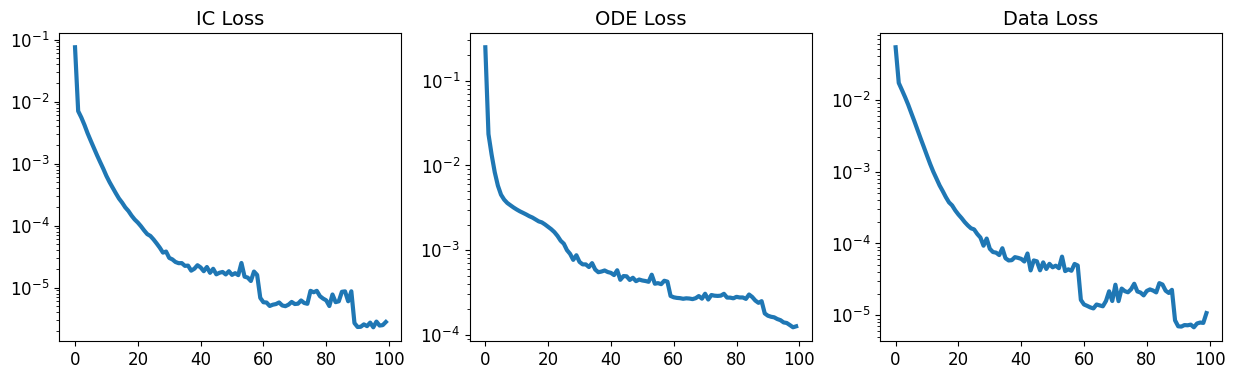

In [17]:
# History for loss
%matplotlib inline
fig, ax = plt.subplots(1, 3, figsize=(15, 4))
ax[0].plot(range(n_epochs), loss_tracker.loss_history['IC_loss'], lw=3)
ax[1].plot(range(n_epochs), loss_tracker.loss_history['ODE_loss'], lw=3)
ax[2].plot(range(n_epochs), loss_tracker.loss_history['Data_loss'], lw=3)
ax[0].set_title('IC Loss', fontsize=14)
ax[1].set_title('ODE Loss', fontsize=14)
ax[2].set_title('Data Loss', fontsize=14)
for axs in ax:
    axs.set_yscale('log')
    axs.tick_params(axis='both', which='major', labelsize=12)

plt.savefig('loss.png', bbox_inches='tight', pad_inches=0, transparent=True)

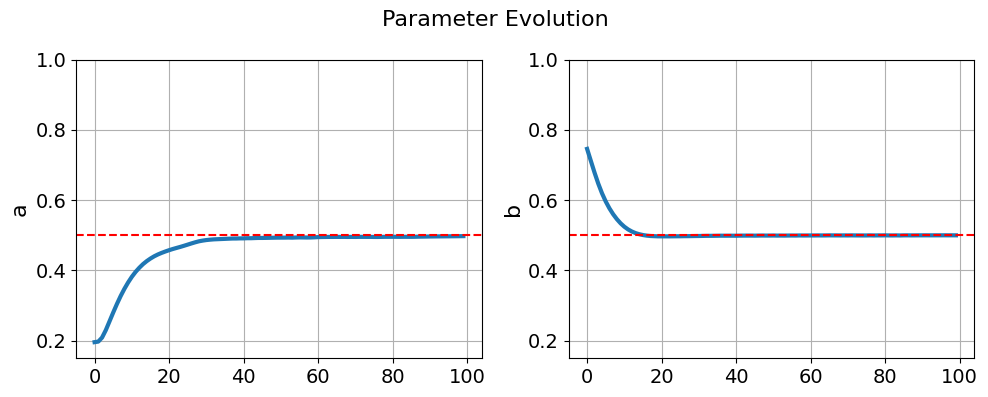

In [18]:
# History for parameters
%matplotlib inline
fig, ax = plt.subplots(1, 2, figsize=(10, 4))
ax[0].plot(range(n_epochs), a_list, lw=3)
ax[0].set_ylabel('a', fontsize=16)

ax[1].plot(range(n_epochs), b_list, lw=3)
ax[1].set_ylabel('b', fontsize=16)

for axs in ax:
    axs.tick_params(axis='both', which='major', labelsize=14)
    axs.set_ylim((0.15, 1.0))
    axs.grid(True)
    axs.axhline(y=0.5, color='r', linestyle='--')
fig.suptitle('Parameter Evolution', fontsize=16)
plt.tight_layout()
plt.savefig('inverse_param_estimate.png', bbox_inches='tight', pad_inches=0, transparent=True)